# Notebook for light curve plotting

We will be using the -------- data for production of the Light curve. 

## Load the modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=20)   
plt.rc('ytick', labelsize=20)
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=25)

import numpy as np
import astropy.units as u
from pathlib import Path
import glob
from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion, PointSkyRegion
import pickle

from scipy.stats import chi2
from functools import partial
import scipy.special as scipys

## Gammapy modules

In [2]:
from gammapy.modeling import Fit
import gammapy.irf as irf
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation, Observations, DataStore
from gammapy.utils.random import get_random_state
from gammapy.maps import MapAxis
from gammapy.analysis import Analysis, AnalysisConfig



# models modules
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    PointSpatialModel,
    GaussianSpatialModel,
    TemplateSpatialModel,
    FoVBackgroundModel,
    SpectralModel,
    #Parameter, 
    TemplateSpectralModel
)
# dataset modules
from gammapy.datasets import (
    MapDataset, 
    MapDatasetOnOff, 
    MapDatasetEventSampler,
    SpectrumDatasetOnOff,
    SpectrumDataset, 
    Datasets,
    FluxPointsDataset
)

from gammapy.maps import MapAxis, WcsGeom, Map, RegionGeom
from gammapy.makers import SafeMaskMaker, MapDatasetMaker, SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker, WobbleRegionsFinder
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator
from gammapy.visualization import plot_spectrum_datasets_off_regions

## Load the DL3 data

In [548]:
datastore = DataStore.from_dir(f"/Users/batkovic/Desktop/phd/arqus_school_2022/hands_on/1_read_data/data_test/")

observations = ()


observations = datastore.get_observations(obs_id=[5029747], required_irf='point-like')

# FOR THE CASE WHERE WE WANT ALL THE RUNS LISTED IN THE HDU AND OBS TABLES
#observation = datastore.get_observations([5029747], required_irf='point-like')



In [549]:
print(observations)

Observations
Number of observations: 1
Observation

	obs id            : 5029747 
 	tstart            : 56569.18
	tstop             : 56569.19
	duration          : 1188.00 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 0.6%



In [550]:
target_position = SkyCoord.from_name('Crab Nebula', frame="icrs")

theta = observations_crab[0].aeff.meta['RAD_MAX']
assert all(o.aeff.meta['RAD_MAX'] == theta for o in observations_crab)

on_region_radius = Angle(theta*u.deg)
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

skydir = target_position.galactic

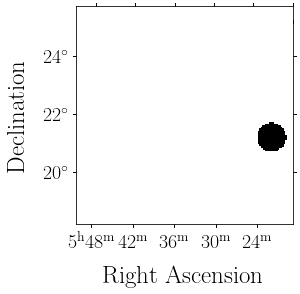

In [551]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(183.604, -8.708, unit="deg", frame="galactic"),
    radius=0.5* u.deg,
)
skydir = target_position.galactic
geom =  WcsGeom.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)

exclusion_mask = ~geom.region_mask([exclusion_region])
exclusion_mask.plot();

In [552]:
energy_axis = MapAxis.from_energy_bounds(
    50, 1e5, nbin=5, per_decade=True, unit="GeV", name="energy")

energy_axis_true = MapAxis.from_energy_bounds(
    10, 1e5, nbin=10, per_decade=True, unit="GeV", name="energy_true")  

geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true
)

In [553]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False,
    selection=["counts", "exposure", "edisp"]
)

# tell the background maker to use the WobbleRegionsFinder, let us use 1 off
region_finder = WobbleRegionsFinder(n_off_regions=3)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

# use the energy threshold specified in the DL3 files
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"])

In [554]:
# Logparabola model with start values for Crab! Might be better to use already published values for your source.
logparabola_model = LogParabolaSpectralModel(
    amplitude=1e-10 * u.Unit("TeV-1 cm-2 s-1"),
    reference=0.3 * u.TeV,
    alpha=2.31 * u.Unit(""),
    beta=0.26 * u.Unit("")
)
model = SkyModel(spectral_model=logparabola_model.copy(), name="logp_crab")

In [555]:
datasets = Datasets()
for obs_id, observation in zip(observations.ids, observations):
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_id)), observation
    )
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    if dataset_on_off.counts_off:
        datasets.append(dataset_on_off)
    else:
        print(f"No Off counts in set {obs_id}")

In [556]:
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 5029747
  Instrument : Unknown
  Models     : 




No we can plot the off regions and target positions on top of the counts map:

/Users/batkovic/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/batkovic/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:162: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


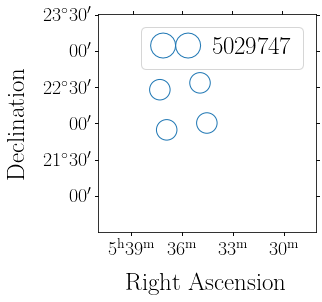

In [557]:
counts = Map.create(skydir=target_position, width=3)
ax = counts.plot()
geom.plot_region(ax=ax, kwargs_point={"color": "k", "marker": "*"})
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)

In [558]:
for dataset in datasets:
        dataset.models = model

In [559]:
datasets.models = [model]

fit = Fit()
result = fit.run(datasets=datasets)
print(result)
best_fit_model = model.copy()
print(best_fit_model)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 119
	total stat : 11.94

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

SkyModel

  Name                      : dseG3tCY
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   7.90e-10   +/- 5.8e-11 1 / (cm2 s TeV)
    reference             (frozen):      0.300       TeV         
    alpha                         :      2.146   +/-    0.12             
    beta                          :      0.234   +/-    0.08             




In [560]:
# Set up the lightcurve maker
# The energy edges here are for the integration of the spectrum we just fitted.
# If reoptimize=False, the spectral parameters are not fitted again.
# The index is always fitted to the data contained in one LC bin.
# If you didn't fit the spectrum to your data before, use reoptimize=True!
# Otherwise, your flux points could be incorrect.
# The parameter "source" is misleading here, it means the name of the spectrum you add to your data sets.
# You could add more than one model to your data set to compare them, for example
# With time_intervals, you can specify a time binning
lc_maker_1d = LightCurveEstimator(
    energy_edges=[0.1, 50] * u.TeV,
    source="logp_crab",
    reoptimize=False,
#     time_intervals=None,
)

In [561]:
lc_1d = lc_maker_1d.run(datasets)

In [562]:
# Set upper limits
#lc_1d.table["is_ul"] = (lc_1d.table["sqrt_ts"] < 3) | (np.isnan(lc_1d.table["sqrt_ts"]))

<AxesSubplot:xlabel='Time [iso]', ylabel='dnde (1 / (cm2 s TeV))'>

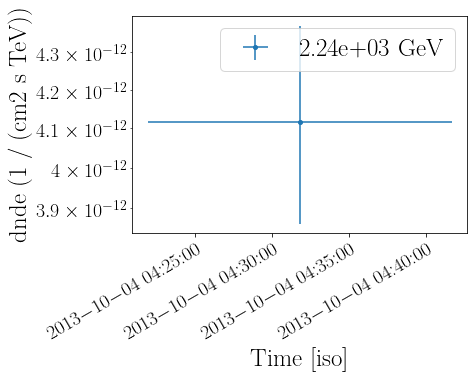

In [563]:
lc_1d.plot(axis_name="time")

Just checking the start and stop time 

In [533]:
t_min = round((datasets.gti.time_start).value[0]) - 0.5
start

56569.181865555554

In [534]:
t_max = round((datasets.gti.time_stop.value[0])) + 0.5
stop

56569.19561555555

Defining the bins with the time intervals

Let's first check the start time in iso format, needed to divide the intervals.

In [564]:
print(observations[0].gti)

GTI info:
- Number of GTIs: 1
- Duration: 1188.0 s
- Start: 56569.18108796296 MET
- Start: 2013-10-04T04:20:46.000 (time standard: UTC)
- Stop: 56569.19483796296 MET
- Stop: 2013-10-04T04:40:34.000 (time standard: UTC)



In [565]:
t0 = Time("2013-10-04T04:20:46.000")
duration = 1188.0 * u.s
n_time_bins = 11
times = t0 + np.arange(n_time_bins) * duration
time_intervals = [
    Time([tstart, tstop]) for tstart, tstop in zip(times[:-1], times[1:])
] 
print(time_intervals[0].mjd)

[56569.18108796 56569.19483796]


In [566]:
time_intervals

[<Time object: scale='utc' format='isot' value=['2013-10-04T04:20:46.000' '2013-10-04T04:40:34.000']>,
 <Time object: scale='utc' format='isot' value=['2013-10-04T04:40:34.000' '2013-10-04T05:00:22.000']>,
 <Time object: scale='utc' format='isot' value=['2013-10-04T05:00:22.000' '2013-10-04T05:20:10.000']>,
 <Time object: scale='utc' format='isot' value=['2013-10-04T05:20:10.000' '2013-10-04T05:39:58.000']>,
 <Time object: scale='utc' format='isot' value=['2013-10-04T05:39:58.000' '2013-10-04T05:59:46.000']>,
 <Time object: scale='utc' format='isot' value=['2013-10-04T05:59:46.000' '2013-10-04T06:19:34.000']>,
 <Time object: scale='utc' format='isot' value=['2013-10-04T06:19:34.000' '2013-10-04T06:39:22.000']>,
 <Time object: scale='utc' format='isot' value=['2013-10-04T06:39:22.000' '2013-10-04T06:59:10.000']>,
 <Time object: scale='utc' format='isot' value=['2013-10-04T06:59:10.000' '2013-10-04T07:18:58.000']>,
 <Time object: scale='utc' format='isot' value=['2013-10-04T07:18:58.000'

To divide the observations, one needs to select them based on their start and stop times and create new observations.

In [538]:
##select_time() is by gammapy, we need to define our own function

#short_observations = ()
short_observations = observations.select_time(time_intervals)
# check that observations have been filtered
print(
    f"Number of observations after time filtering: {len(short_observations)}\n"
)
print(short_observations[0].gti)

Number of observations after time filtering: 2

GTI info:
- Number of GTIs: 1
- Duration: 1188.0 s
- Start: 56569.18108796296 MET
- Start: 2013-10-04T04:20:46.000 (time standard: UTC)
- Stop: 56569.19483796296 MET
- Stop: 2013-10-04T04:40:34.000 (time standard: UTC)



In [539]:
#energy_axis = MapAxis.from_energy_bounds(
#    50, 1e5, nbin=5, per_decade=True, unit="GeV", name="energy")

#energy_axis_true = MapAxis.from_energy_bounds(
#    10, 1e5, nbin=10, per_decade=True, unit="GeV", name="energy_true")  

energy_axis = MapAxis.from_energy_bounds("0.4 TeV", "20 TeV", nbin=10)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.1 TeV", "40 TeV", nbin=20, name="energy_true"
)


geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true
)

In [540]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False,
    selection=["counts", "exposure", "edisp"]
)

# tell the background maker to use the WobbleRegionsFinder, let us use 1 off
region_finder = WobbleRegionsFinder(n_off_regions=3)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

# use the energy threshold specified in the DL3 files
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"])

After dividing the observations, we need to create the datasets again from the new, "shorter" observations and build a light curve maker with given time intervals:

In [541]:
logparabola_model = LogParabolaSpectralModel(
    amplitude=1e-10 * u.Unit("TeV-1 cm-2 s-1"),
    reference=0.3 * u.TeV,
    alpha=2.31 * u.Unit(""),
    beta=0.26 * u.Unit("")
)
model = SkyModel(spectral_model=logparabola_model.copy(), name="logp_crab")

In [542]:
datasets = Datasets()

dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true
)

for obs in short_observations:
    dataset = dataset_maker.run(dataset_empty.copy(), obs)

    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)
    


/Users/batkovic/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [543]:
datasets.models = model

In [544]:
time_intervals

[<Time object: scale='utc' format='isot' value=['2013-10-04T04:20:46.000' '2013-10-04T04:40:34.000']>,
 <Time object: scale='utc' format='isot' value=['2013-10-04T04:40:34.000' '2013-10-04T05:00:22.000']>,
 <Time object: scale='utc' format='isot' value=['2013-10-04T05:00:22.000' '2013-10-04T05:20:10.000']>,
 <Time object: scale='utc' format='isot' value=['2013-10-04T05:20:10.000' '2013-10-04T05:39:58.000']>,
 <Time object: scale='utc' format='isot' value=['2013-10-04T05:39:58.000' '2013-10-04T05:59:46.000']>,
 <Time object: scale='utc' format='isot' value=['2013-10-04T05:59:46.000' '2013-10-04T06:19:34.000']>,
 <Time object: scale='utc' format='isot' value=['2013-10-04T06:19:34.000' '2013-10-04T06:39:22.000']>,
 <Time object: scale='utc' format='isot' value=['2013-10-04T06:39:22.000' '2013-10-04T06:59:10.000']>,
 <Time object: scale='utc' format='isot' value=['2013-10-04T06:59:10.000' '2013-10-04T07:18:58.000']>,
 <Time object: scale='utc' format='isot' value=['2013-10-04T07:18:58.000'

In [567]:
lc_maker_1d = LightCurveEstimator(
    energy_edges=[0.7, 20] * u.TeV,
    source="logp_crab",
    time_intervals=time_intervals,
    selection_optional=None,
)

In [568]:
lc_1d = lc_maker_1d.run(datasets)

<AxesSubplot:xlabel='Energy [GeV]', ylabel='dnde (1 / (cm2 s TeV))'>

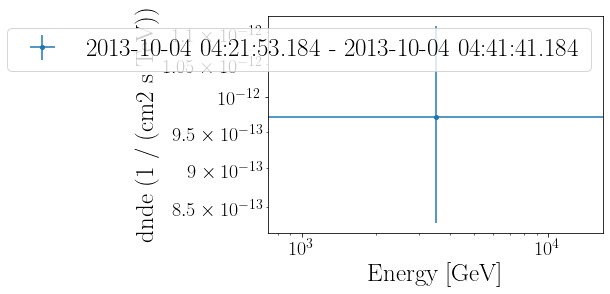

In [569]:
lc_1d.plot(marker="o")